## k-vs-(N-k) Flu ABM Env
- k-vs-(N-k) experiment
- Kicking tires on multiplayer instance of Flu ABM with RL learners 
- MADDPG/MAC RL algo

In [1]:
import itertools, importlib, sys, warnings, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ML libs
import tensorflow as tf
print("Tensorflow version:", tf.__version__)
# warnings.filterwarnings("ignore")

log_path = './log/flu'
#tensorboard --logdir=flugame_worker_1:'./log/train_rf_flugame_worker'

## suppress annoy verbose tf msgs
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # '3' to block all including error msgs
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Tensorflow version: 1.15.0


In [2]:
sys.path.append('./embodied_arch')
import embodied_arch.embodied_central_Qcritic as emac
importlib.reload(emac)

<module 'embodied_arch.embodied_central_Qcritic' from '/mnt/Lebesgue/Documents/Research/Coding/Python/rlabms/embodied_arch/embodied_central_Qcritic.py'>

In [3]:
import flumodel_python.flu_env as Fenv
from embodied_misc import ActionPolicyNetwork, ValueNetwork, SensoriumNetworkTemplate

## Env Setup

In [4]:
# exos = [1,2,3,10]  # (np.random.sample(33) < 0.3)
exos = (np.random.sample(9223) < 0.004)
exos = [j for j in range(len(exos)) if exos[j]==True]
print(len(exos))

importlib.reload(Fenv);
importlib.reload(emac);

38


In [5]:
tf.reset_default_graph()
flu_menv = Fenv.Flu_env(
    exo_idx=exos,
    model_path="./flumodel_python/"
)

In [6]:
print(flu_menv.actor_count)
print(flu_menv.state_space_size, flu_menv.action_space_size)

38
8 1


### MARL Setup Demo

In [7]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(8,), gamma_reg=1e-1)
value = lambda s: ValueNetwork(s, hSeq=(8,), gamma_reg=1.)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, hSeq=(16,8,8,), out_dim=out_dim, gamma_reg=5.)

# num_episodes, n_epochs, max_len = (5, 4, 5)
# num_episodes, n_epochs, max_len = (100, 1501, 35)
# num_episodes, max_len, n_epochs, evry = (25, 10, 121, 40)
num_episodes, max_len, n_epochs, evry = (100, 35, 451, 50)

In [8]:
flumac = emac.EmbodiedAgent_MAC(
    name="flu_MAC", env_=flu_menv, 
    alpha_p=150., alpha_v=5., alpha_q=2.5,
    actorNN=actor, valueNN=value,
    sensorium=sensor,latentDim=4, 
    max_episode_length=max_len,
    _every_=evry
)

# ??flumac.play
# (flumac.a_size, flumac.env.action_space_size)

In [9]:
sess = tf.InteractiveSession()
flumac.init_graph(sess) # note tboard log dir
saver = tf.train.Saver(max_to_keep=1) 

Tensorboard logs in:  ./log/train_flu_MAC


## Baseline

### Baseline for RL/Adaptive Behavioral Model

In [10]:
print('Baselining untrained pnet...')
rwds0 = []
acts_cov = np.zeros([flumac.actor_count,flumac.actor_count])
for k in range(num_episodes):
    flumac.play(sess, terminal_reward=0.);
    rwds0.append(flumac.last_total_returns)
    actions = np.array(flumac.episode_buffer['actions']).T
    acts_cov = acts_cov + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

# Compute average rewards
base_perf = 100.*np.mean(np.array(rwds0)/float(flumac.max_episode_length))
base_per_agent = 100.*np.mean(np.array(rwds0)/float(flumac.max_episode_length), axis=0)

print("\nAgent is flu-free for an average of {}pct of seasons".format(
    1.*base_perf))

Baselining untrained pnet...
Episode 99/100
Agent is flu-free for an average of 94.24887218045114pct of seasons


Agent Action Correlations:


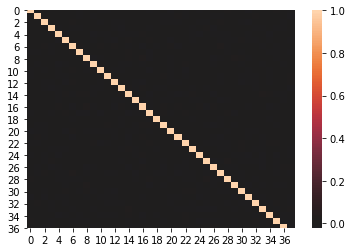

In [11]:
acts_corr = acts_cov.copy()
jm, km = acts_corr.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_corr[j,j])*(acts_corr[k,k]))
        acts_corr[j,k] = acts_corr[j,k]/denom

print("Agent Action Correlations:")
sns.heatmap(acts_corr, center=0)

## Train Agent Population

	Iteration 25: Value loss(11.861095428466797)

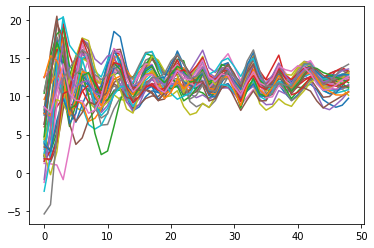

In [12]:
obs = []
for ct in range(50):
    flumac.play(sess)
    tmp = flumac.train_eval_QC(sess)
    obs.append(np.mean(tmp, axis=0))
    if ct%25==0:
        print('\r\tIteration {}: Value loss({})'.format(
            ct, np.mean(tmp)), end="")
plt.plot(obs[1:]);

In [13]:
# ### Train Agents
print('Training...')
hist = flumac.work(sess, num_epochs=n_epochs, saver=saver)

Training...
Starting agent flu_MAC
Epoch no.: 0/451

	Stats @Step 0: 	(Min, Mean, Max)
Perf/Recent Rewards: (25.0, 32.55263157894737, 35.0)
Losses/Policy LLs: (-2.2608888, -0.60087085, -0.11010261)
Losses/Policy Entropies: (0.33433878, 0.6049257, 0.6931392)
Values/Critic Scores: (-4.1316667, 0.23619446, 3.2716048)
Values/Mean Q Scores: (13.148774, 17.42588, 19.983746)
Saved Model
Epoch no.: 50/451

	Stats @Step 50: 	(Min, Mean, Max)
Perf/Recent Rewards: (27.0, 32.973684210526315, 35.0)
Losses/Policy LLs: (-2.8019228, -0.58850634, -0.06261318)
Losses/Policy Entropies: (0.22887048, 0.59595674, 0.6928854)
Values/Critic Scores: (-3.635611, 0.1409748, 3.0927284)
Values/Mean Q Scores: (21.384138, 25.468422, 27.90224)
Saved Model
Epoch no.: 100/451

	Stats @Step 100: 	(Min, Mean, Max)
Perf/Recent Rewards: (26.0, 32.921052631578945, 35.0)
Losses/Policy LLs: (-2.313823, -0.5986697, -0.104119614)
Losses/Policy Entropies: (0.3226206, 0.6056469, 0.6927041)
Values/Critic Scores: (-6.481694, 0.04114

## Test

In [14]:
# Test pnet!
print('Testing...')
rwds = []
acts_cov_trained = np.zeros([flumac.actor_count,flumac.actor_count])
for k in range(num_episodes):
    flumac.play(sess)
    rwds.append(flumac.last_total_returns)
    actions = np.array(flumac.episode_buffer['actions']).T
    acts_cov_trained = acts_cov_trained + (np.cov(actions)/num_episodes)
    print("\rEpisode {}/{}".format(k, num_episodes),end="")

trained_perf = 100.*np.mean(np.array(rwds)/float(flumac.max_episode_length))
trained_per_agent = 100.*np.mean(np.array(rwds)/float(flumac.max_episode_length), axis=0)

print("\nAgent is flu-free for an average of {} pct compared to baseline of {} pct".format(
    1.*trained_perf, 1.*base_perf) )

Testing...
Episode 99/100
Agent is flu-free for an average of 95.28571428571429 pct compared to baseline of 94.24887218045114 pct


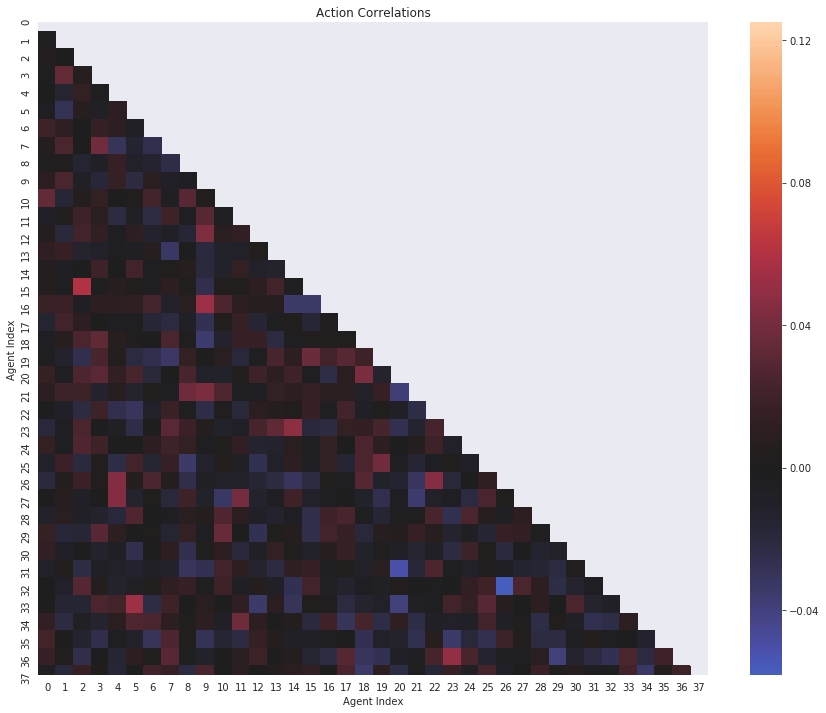

In [15]:
acts_corr_trained = acts_cov_trained.copy()
jm, km = acts_corr_trained.shape
for j in range(jm):
    for k in range(km):
        denom = np.sqrt((acts_cov_trained[j,j])*(acts_cov_trained[k,k]))
        acts_corr_trained[j,k] = acts_corr_trained[j,k]/denom

mask = np.zeros_like(acts_corr_trained)
mask[np.triu_indices_from(mask,k=0)] = True
with sns.axes_style("darkgrid"):
    plt.rcParams['figure.figsize'] = (15, 12)
    ax = sns.heatmap(acts_corr_trained, 
                     mask=mask, vmax=0.125, center=0)
    ax.set_ylabel("Agent Index")
    ax.set_xlabel("Agent Index")
    ax.set_title("Action Correlations")

## Evaluate

In [16]:
rwds0_df = pd.DataFrame(100.*(np.array(rwds0)/float(flumac.max_episode_length)))
rwds_df = pd.DataFrame(100.*(np.array(rwds)/float(flumac.max_episode_length)))

rwds0_df['Wave'] = "Baseline"
rwds_df['Wave'] = "Trained"

resDF = pd.concat([rwds0_df, rwds_df])
resDF.columns = ["Agent"+str(tc) if tc is not "Wave" else tc for tc in resDF.columns]
# resDF['id'] = resDF.index
print(resDF.shape)
# resDF.head()


(200, 39)


In [17]:
resDF = resDF.melt(
    id_vars=['Wave'], #['id', 'Wave'],
    value_vars=[tc for tc in resDF.columns if "Agent" in tc]
)
resDF = resDF.rename(columns={"variable": "Agent", "value": "Immune_pct"})
print(resDF.shape)

res_tabs = resDF.groupby(['Agent','Wave']).aggregate(['mean','std']) # res_tabs

# resDF.head()

(7600, 3)


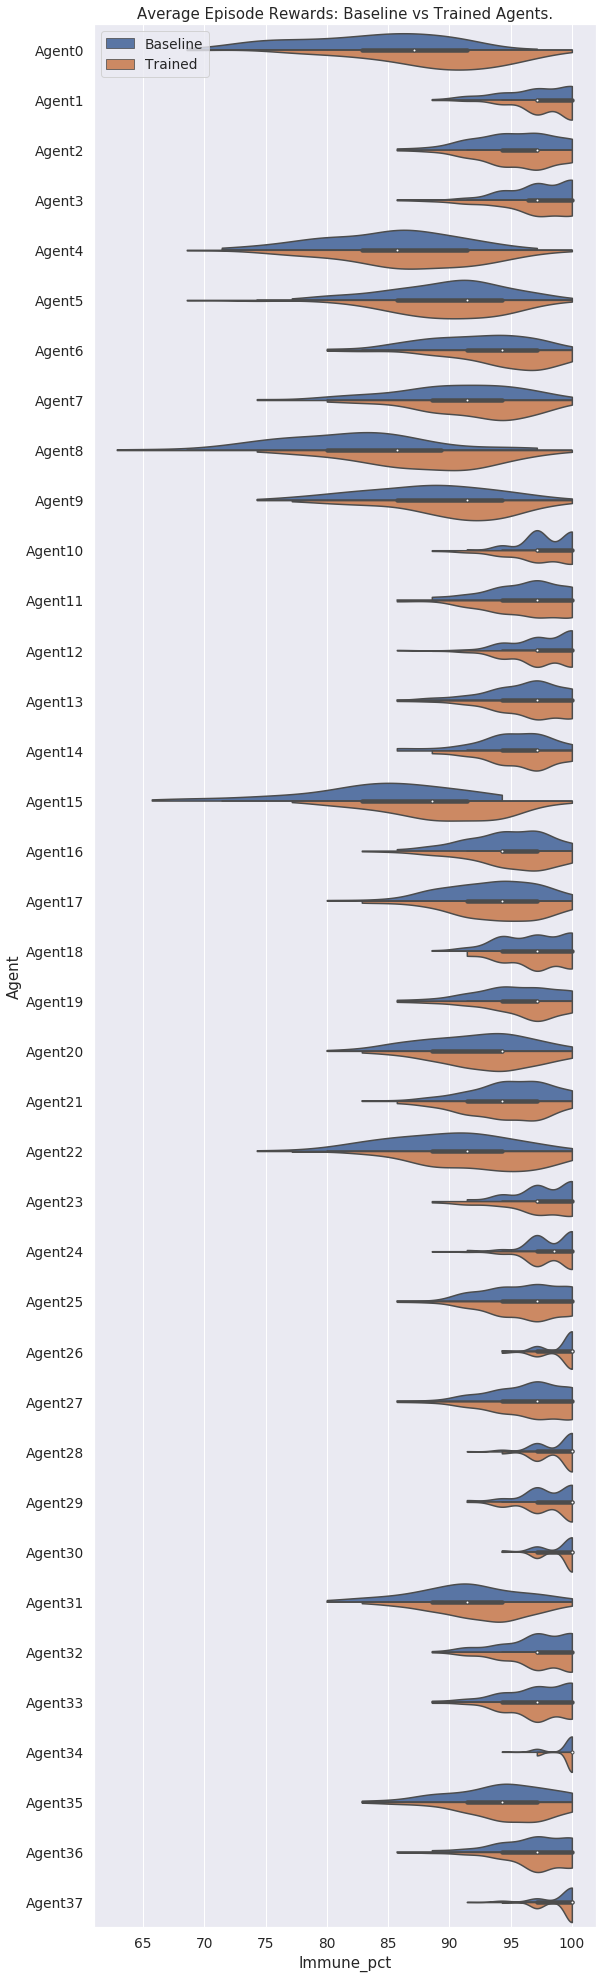

In [18]:
plt.rcParams['figure.figsize'] = (9, 35)
sns.set(font_scale=1.25)

fig = sns.violinplot(data=resDF, inner="box", cut=0,
                     x="Immune_pct", y="Agent", hue="Wave",
                     split=True);
fig.set_title(
    'Average Episode Rewards: Baseline vs Trained Agents.');
fig.legend(loc='upper left');

In [19]:
base_meanDF = resDF[resDF.Wave=="Baseline"].groupby(['Agent']).aggregate(['mean'])
base_meanDF.sort_index(inplace=True)

trained_meanDF = resDF[resDF.Wave=="Trained"].groupby(['Agent']).aggregate(['mean'])
trained_meanDF.sort_index(inplace=True)

mean_diffDF = (trained_meanDF - base_meanDF)
mean_diffDF.columns = ['Mean_Immune_Pct_Change']
# mean_diffDF.head()

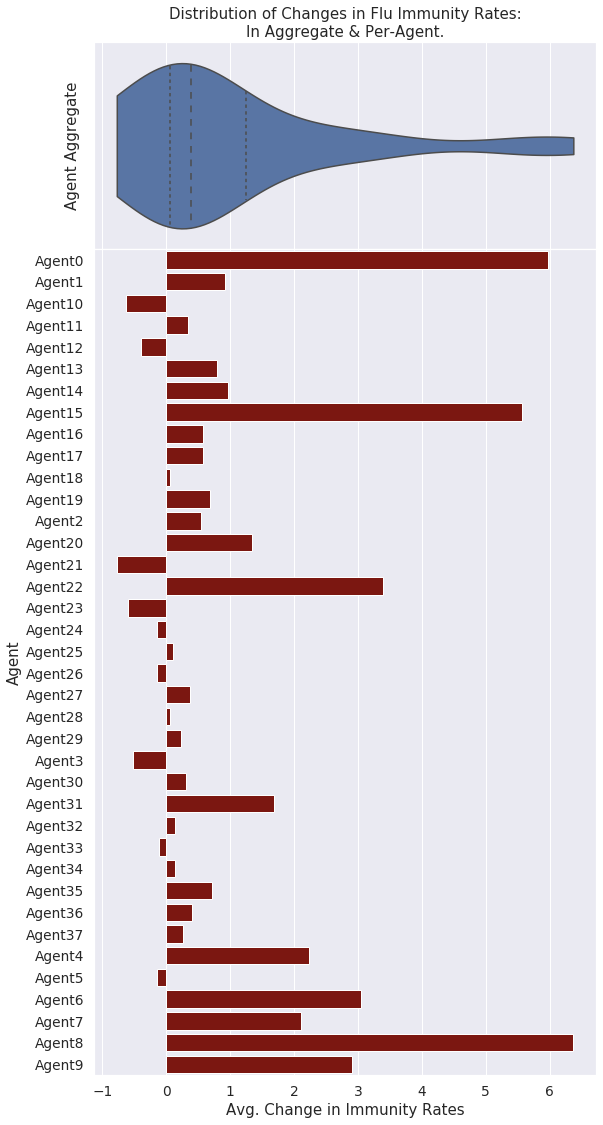

In [20]:
plt.rcParams['figure.figsize'] = (9, 19)
sns.set_color_codes("dark")
fig, axs = plt.subplots(2,1, sharex=True, gridspec_kw={'height_ratios': [1,4]})
cmp = sns.violinplot(x='Mean_Immune_Pct_Change', cut=0, inner='quartile',
                     data=mean_diffDF, ax=axs[0])
axs[0].set_ylabel('Agent Aggregate');
axs[0].set_title(
    'Distribution of Changes in Flu Immunity Rates:\nIn Aggregate & Per-Agent.'
);

sns.barplot(y=mean_diffDF.index, x="Mean_Immune_Pct_Change", 
            data=mean_diffDF, color="r",
            label="Success Rate", ax=axs[1]);
plt.subplots_adjust(wspace=0, hspace=0)
axs[1].set_xlabel('Avg. Change in Immunity Rates');

### Baseline for Default Behavioral Model

In [21]:
import flumodel_python.flu_env_basic as FABM
# ?Fenv.Flu_ABM
importlib.reload(FABM);
flu = FABM.Flu_ABM(model_path="./flumodel_python/")

# Burn-in Flu ABM First...
for _ in range(30):
    _ = flu.stepAll()

In [22]:
flu_hist = np.zeros([num_episodes, len(exos)])
for k in range(num_episodes):
    tmp = np.zeros(len(exos))
    for _ in range(max_len):
        tmp += (1.-np.array(flu.stepAll(), dtype=float))[exos]
    flu_hist[k,:] = tmp

In [23]:
rwds_dbm = 100.*flu_hist/float(max_len)
print(len(exos), rwds_dbm.shape, 
      np.mean(rwds_dbm, axis=0).shape)

38 (100, 38) (38,)


In [29]:
print(np.mean(rwds_dbm), "\n",
      np.mean(rwds_dbm, axis=0)
     )

94.46466165413533 
 [85.68571429 97.2        93.74285714 96.88571429 78.94285714 88.94285714
 92.11428571 93.08571429 85.05714286 90.17142857 96.85714286 96.42857143
 97.2        97.57142857 94.28571429 86.34285714 93.65714286 92.94285714
 95.17142857 94.34285714 93.62857143 94.45714286 92.71428571 97.97142857
 98.45714286 96.57142857 99.08571429 97.22857143 98.68571429 98.68571429
 99.22857143 92.08571429 97.28571429 97.         99.48571429 94.51428571
 96.74285714 99.2       ]


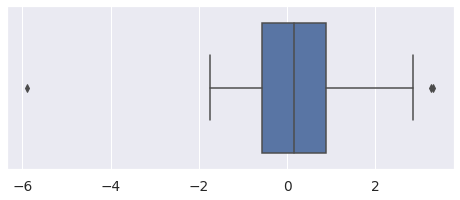

In [25]:
plt.rcParams['figure.figsize'] = (8,3)
sns.boxplot(np.mean(rwds_dbm, axis=0) - base_per_agent)

### Compare to Default Behavioral Model

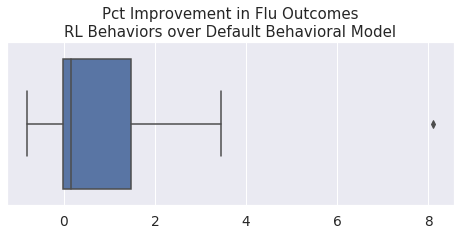

In [33]:
trcmp = 100.*(np.array(rwds)/float(flumac.max_episode_length))
cmp = np.mean((trcmp-rwds_dbm), axis=0)
bplot = sns.boxplot(cmp)
bplot.set_title(
    'Pct Improvement in Flu Outcomes\nRL Behaviors over Default Behavioral Model');

In [28]:
plt.rcParams['figure.figsize'] = (8,3)

np.mean(trcmp - np.mean(rwds_dbm, axis=0))

0.8210526315789657